In [1]:
%load_ext autoreload
%autoreload 2

### Setup

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import DATA_DIR, ROOT_DIR, PLOT_DIR
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataloader import get_nd_array, get_slice
from download.hf import pull_predictions_from_hf

import metaanalysis
plt.close()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # ignore fitting warnings

# Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

### Load Data

In [3]:
local_path = f'{DATA_DIR}/benchmarks.parquet'
df_benchmarks = pd.read_parquet(local_path)
print(f'Loaded {len(df_benchmarks):,} model evaluations')

Loaded 810,570 model evaluations


In [4]:
from utils import extract_flops

df_benchmarks["model_path"] = df_benchmarks["model_config"].apply(lambda x: x["model_path"])
df_benchmarks[["flops", "observational_model"]] = df_benchmarks["model_path"].apply(extract_flops).apply(pd.Series)

In [5]:
df_benchmarks["flops"].unique()

TARGET_FLOPS = {
    'olmo2_1b': 3.6e22,
    'olmo2_7b': 1.68e23,
    'olmo2_13b': 3.9e23, 
    'olmo2_32b': 1.15e24,
}

flops = df_benchmarks[["flops", "model_path"]].dropna()
models_in_range = {}
for model, target in TARGET_FLOPS.items():
    lower = target / 1.7
    upper = target * 1.7
    filtered = flops[(flops['flops'] >= lower) & (flops['flops'] <= upper)]
    models_in_range[model] = {
        'count': len(filtered['model_path'].unique()),
        'flops_target': target,
        'flops_range': (lower, upper)
    }

models_in_range

{'olmo2_1b': {'count': 8,
  'flops_target': 3.6e+22,
  'flops_range': (2.1176470588235293e+22, 6.12e+22)},
 'olmo2_7b': {'count': 13,
  'flops_target': 1.68e+23,
  'flops_range': (9.88235294117647e+22, 2.8559999999999996e+23)},
 'olmo2_13b': {'count': 7,
  'flops_target': 3.9e+23,
  'flops_range': (2.2941176470588235e+23, 6.63e+23)},
 'olmo2_32b': {'count': 11,
  'flops_target': 1.15e+24,
  'flops_range': (6.764705882352941e+23, 1.955e+24)}}

In [6]:
from datadecide import get_compute
from utils.constants_models import DDOS_MODEL_NAMES

observational_models = sorted(df_benchmarks[df_benchmarks['observational_model'] == True]['model'].unique())
datadecide_models = DDOS_MODEL_NAMES

# Add FLOPs col for DataDecide
datadecide_mask = df_benchmarks['model'].isin(datadecide_models)
df_benchmarks.loc[datadecide_mask, 'flops'] = df_benchmarks.loc[datadecide_mask, 'size'].apply(get_compute).astype('float64')

In [7]:
benchmark_tasks = set(df_benchmarks['task'].unique())
TASKS = sorted(list(benchmark_tasks))

In [8]:
df_instances = None

In [9]:
selected_tasks = [
    t
    for t in TASKS
    if ":" not in t 
    and "bbh" not in t and "paloma" not in t and "llm_compression" not in t 
    and "custom_loss" not in t and "coqa" not in t and "deepmind" not in t
]

selected_tasks += [
    t
    for t in TASKS
    if ":mc" in t
    and "bbh" not in t and "paloma" not in t and "llm_compression" not in t
    and "custom_loss" not in t and "coqa" not in t and "deepmind" not in t
]

mmlu      = [t for t in TASKS if 'mmlu' in t and ':' not in t and '_pro_' not in t]
minerva   = [t for t in TASKS if 'minerva' in t and ':' not in t]
mmlu_pro  = [t for t in TASKS if '_pro_' in t and ':rc' in t]
mmlu_mc   = [t for t in TASKS if 'mmlu' in t and ':mc' in t and '_pro_' not in t]
olmes     = ['arc_challenge', 'arc_easy', 'boolq', 'csqa', 'hellaswag', 'openbookqa', 'piqa', 'socialiqa', 'winogrande']
olmes_mc  = [f'{task}:mc' for task in olmes]
olmes_para        = [f'{task}:para' for task in olmes]
olmes_distractors = [f'{task}:distractors' for task in olmes]
olmes_enlarge     = [f'{task}:enlarge' for task in olmes]
# olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'naturalqs', 'squad', 'triviaqa']
olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'squad', 'triviaqa']
agi_eval  = [t for t in TASKS if 'agi_eval' in t and ':rc' in t]
bbh       = [t for t in TASKS if 'bbh' in t and ':' not in t]
paloma    = [t for t in TASKS if 'paloma' in t]
llm_compression = [t for t in TASKS if 'llm_compression' in t]
custom_loss = [t for t in TASKS if 'custom_loss' in t]

In [10]:
from utils import get_title_from_task

def add_multitask_avg(df_benchmarks, task_set):
    _slice = get_slice(df_benchmarks, task=task_set)

    new_task = _slice.fillna('')
    new_task = new_task.groupby(['model', 'step', 'mix', 'size'])[['model_config', 'primary_score', 'logits_per_byte_corr', 'logits_per_char_corr']]
    new_task = new_task.agg(lambda x: x.iloc[0] if x.name == 'model_config' else x[pd.to_numeric(x, errors='coerce').notnull()].mean())
    new_task = new_task.reset_index()

    new_task['step'] = pd.to_numeric(new_task['step'], errors='coerce') 
    # new_task['size'] = pd.to_numeric(new_task['size'], errors='coerce')

    new_task['task'] = get_title_from_task(task_set)

    # Append the aggregate task entries to df_benchmarks
    df_benchmarks = pd.concat([df_benchmarks, new_task], axis=0)

    return df_benchmarks

# new task suites
multitask_math = ["gsm_plus", "gsm_symbolic_main", "gsm_symbolic_p1", "gsm_symbolic_p2", "minerva_math_500"] + ['gsm8k'] + ['minerva'] # 6 # "aime"
multitask_code = ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] # 4
multitask_knowledge = ["medmcqa", 'autobencher'] + olmes + ['mmlu'] + olmes_gen + ['mmlu_pro'] + ['agi_eval'] # 19
multitask = multitask_knowledge + multitask_math + multitask_code # 30 # bbh
olmes_all = olmes + mmlu + olmes_gen

# Re-order tasks so that the title logic works (a bit hacky, yes)
olmes_all = ['jeopardy'] + list(set(olmes_all) - {'jeopardy'})
multitask = ['boolq'] + list(set(multitask) - {'boolq'})

df_benchmarks = add_multitask_avg(df_benchmarks, task_set=mmlu)
df_benchmarks = add_multitask_avg(df_benchmarks, task_set=mmlu_pro)
df_benchmarks = add_multitask_avg(df_benchmarks, task_set=agi_eval)
df_benchmarks = add_multitask_avg(df_benchmarks, task_set=minerva)
df_benchmarks = add_multitask_avg(df_benchmarks, task_set=multitask_math)
df_benchmarks = add_multitask_avg(df_benchmarks, task_set=multitask_code)
df_benchmarks = add_multitask_avg(df_benchmarks, task_set=multitask_knowledge)
df_benchmarks = add_multitask_avg(df_benchmarks, task_set=multitask)

/var/folders/cr/z51hvhb932vbx29jw5hxd9nh0000gn/T/ipykernel_24280/394494844.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_task = _slice.fillna('')
/var/folders/cr/z51hvhb932vbx29jw5hxd9nh0000gn/T/ipykernel_24280/394494844.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_task = _slice.fillna('')
/var/folders/cr/z51hvhb932vbx29jw5hxd9nh0000gn/T/ipykernel_24280/394494844.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) inst

In [11]:
from utils import get_selected_tasks

selected_tasks = get_selected_tasks(TASKS)

selected_tasks += ['multitask_all', 'multitask_math', 'multitask_code', 'multitask_knowledge']

### Investigate Benchmarks

In [12]:
from metaanalysis import compute_metaproperties

df_results = compute_metaproperties(
    df_benchmarks, df_instances, selected_tasks,
    run_irt=False, run_instance_analysis=False, 
    use_parallel=True, quiet=True
)

# df_results = compute_metaproperties(
#     df_benchmarks, df_instances, ['arc_challenge'],
#     run_irt=False, run_instance_analysis=False, 
#     use_parallel=False, quiet=True
# )

Computing benchmark properties:   5%|▌         | 2/37 [06:29<1:33:54, 160.99s/it]

bpb is empty array: [] on model "peteish-moreeval-1B-1xC" for task "aime"
bpb is empty array: [] on model "peteish-moreeval-1B-1xC" for task "aime"
aime failed on ladder fits No scores found for model=peteish-moreeval-1B-1xC, metric=['logits_per_byte_corr', 'primary_score'], task=aime. Seeing: []
Failed to calculate compute cost: num_instances should be constant across task=multitask_all for task_as_list=['multitask_all']
Failed to calculate compute cost: num_instances should be constant across task=multitask_math for task_as_list=['multitask_math']
Failed to calculate compute cost: num_instances should be constant across task=multitask_code for task_as_list=['multitask_code']
Failed to calculate compute cost: num_instances should be constant across task=multitask_knowledge for task_as_list=['multitask_knowledge']


Computing benchmark properties: 100%|██████████| 37/37 [13:01<00:00, 21.12s/it]  


In [29]:
from utils import get_pretty_task_name

sizes = ['1B', '7B', '13B', '32B']

noise_measures = [
    'snr:{metric}:{size}', # signal-to-noise ratio
    'rel_std:{metric}:{size}', # data variance / observational variance
    'step_rel_std:last30:{metric}:{size}', # step-to-step variance
]

metric = 'primary_score'

# Collect all data into a dict
data = {}
for task in df_results.index:
    task_data = df_results.loc[task]
    data[task] = {}
    # Add noise measures for each size
    for size in sizes:
        data[task][size] = {}
        for noise_measure in noise_measures:
            col = noise_measure.format( # e.g., snr:primary_score:1B
                metric=metric,
                size=size
            )
            if col in task_data.index:
                col_no_size = col.replace(f':{size}', '')
                data[task][size][col_no_size] = task_data[col]

# Convert to readable metrics
rows = []
for task, task_data in data.items():
    # Add noise measure rows for each size
    for size, size_data in task_data.items():
        row = {'task': task, 'size': size}
        readable_metrics = {
            f'snr:{metric}': 'SNR',
            f'rel_std:{metric}': '$\\text{CV}_\\text{data}$',
            f'step_rel_std:last30:{metric}': '$\\text{CV}_\\text{step}$',
        }
        row.update({readable_metrics.get(k, k): v for k, v in size_data.items()})
        rows.append(row)

# Pivot table to get tasks as rows and metrics as columns
df_noise = pd.DataFrame(rows)
df_noise = df_noise.pivot(index='task', columns='size')
ordered_cols = []
for group in sizes:
    group_cols = [col for col in df_noise.columns if col[1] == group]
    # Re-order cols
    metric_order = ['SNR', '$\\text{CV}_\\text{data}$', '$\\text{CV}_\\text{step}$']
    group_cols = sorted(group_cols, key=lambda x: metric_order.index(x[0]) if x[0] in metric_order else len(metric_order))
    ordered_cols.extend(group_cols)
df_noise = df_noise.reindex(columns=ordered_cols)

# Remove columns with :mc or paloma in the task name
df_noise = df_noise[~(
    df_noise.index.str.contains(':mc', case=False) |
    df_noise.index.str.contains('paloma', case=False) |
    df_noise.index.str.contains('aime', case=False)
)]

df_noise.index = df_noise.index.map(get_pretty_task_name)

# Sort values
df_noise = df_noise.sort_values(by=('SNR', '1B'), ascending=False)

df_noise

agi_eval
arc_challenge
arc_easy
autobencher
codex_humaneval
codex_humanevalplus
csqa
gsm8k
gsm_plus
gsm_symbolic_main
gsm_symbolic_p1
gsm_symbolic_p2
hellaswag
jeopardy
mbpp
mbppplus
medmcqa
minerva
minerva_math_500
mmlu
mmlu_pro
multitask_all
multitask_code
multitask_knowledge
multitask_math
olmes_core9
openbookqa
piqa
socialiqa
squad
triviaqa
winogrande


SNR $\text{CV}_\text{data}$ $\text{CV}_\text{step}$  \
size                     1B                      1B                      1B   
task                                                                          
HellaSwag         39.767722                0.180203                0.004531   
TriviaQA          28.154720                0.410902                0.014594   
Jeopardy          23.658768                0.374006                0.015808   
OLMES Core 9      19.106970                0.118221                0.006187   
AutoBencher       17.621850                0.263814                0.014971   
MMLU Pro          16.279654                0.246190                0.015123   
MMLU              14.521115                0.138562                0.009542   
PIQA              14.226061                0.057939                0.004073   
WinoGrande        14.124480                0.118142                0.008364   
CommonsenseQA     12.167906                0.119859                0.009850   
ARC Challenge      9.411200                0.192939                0.020501   
SocialIQA          8.733039                0.118558                0.013576   
MedMCQA            8.585109                0.105730                0.012316   
GSM+               8.056658                0.609777                0.075686   
ARC Easy           7.885789                0.102013                0.012936   
GSM Symbolic P1    7.175834                0.831203                0.115834   
SQuAD              6.106745                0.089726                0.014693   
AGI Eval           5.313497                0.104573                0.019681   
OpenBookQA         4.822233                0.145083                0.030086   
GSM8K              3.829144                0.587145                0.153336   
HumanEval+         3.704905                0.481693                0.130015   
HumanEval          3.636344                0.451881                0.124268   
GSM Symbolic P2    3.624749                0.805079                0.222106   
GSM Symbolic       3.049802                0.661573                0.216923   
Minerva MATH       2.276153                0.568342                0.249694   
Minerva MATH 500   0.910857                0.490959                0.539008   
MBPP               0.881369                0.220971                0.250713   
MBPP+              0.880860                0.206712                0.234671   
Knowledge Tasks    0.000000                0.000000                0.006932   
Math Tasks         0.000000                0.000000                0.083796   
All Tasks          0.000000                0.000000                0.007718   
Code Tasks         0.000000                0.000000                0.101690   

                        SNR $\text{CV}_\text{data}$ $\text{CV}_\text{step}$  \
size                     7B                      7B                      7B   
task                                                                          
HellaSwag         23.944478                0.061391                0.002564   
TriviaQA          47.028880                0.135217                0.002875   
Jeopardy          14.382446                0.081931                0.005697   
OLMES Core 9       9.605937                0.039329                0.004094   
AutoBencher       11.415586                0.101896                0.008926   
MMLU Pro          17.444250                0.167862                0.009623   
MMLU               3.387720                0.078229                0.023092   
PIQA               5.314334                0.023418                0.004407   
WinoGrande         7.347723                0.061681                0.008395   
CommonsenseQA      5.658212                0.033167                0.005862   
ARC Challenge      5.853723                0.080919                0.013824   
SocialIQA          5.152418                0.048983                0.009507   
MedMCQA            5.790707                0.051142                0.0088

In [14]:
from plot import TASK_CATEGORIES
from utils import get_title_from_task
from utils import get_pretty_task_name

sizes = ['1B', '7B', '13B', '32B']
metric = 'primary_score'

# Collect all data into a dict
data = {}
for task in df_results.index:
    task_data = df_results.loc[task]
    data[task] = {}
    # Add noise measures for each size
    for size in sizes:
        data[task][size] = {}
        for col in [f'snr:{metric}:{size}', f'rel_std:{metric}:{size}', f'step_rel_std:last30:{metric}:{size}']:
            if col in task_data.index:
                col_no_size = col.replace(f':{size}', '')
                data[task][size][col_no_size] = task_data[col]

# Convert to readable metrics
rows = []
for task, task_data in data.items():
    row = {'task': task}
    for size in sizes:
        if size in task_data:
            size_data = task_data[size]
            snr = size_data.get(f'snr:{metric}', '--')
            rel_std = size_data.get(f'rel_std:{metric}', '--') 
            step_rel_std = size_data.get(f'step_rel_std:last30:{metric}', '--')
            if all(x != '--' for x in [snr, rel_std, step_rel_std]):
                row[size] = f'${snr:.2f}_{{{rel_std:.3f} / {step_rel_std:.3f}}}$'
            else:
                row[size] = '--'
    rows.append(row)

# Create dataframe and format
df_noise = pd.DataFrame(rows)
df_noise = df_noise.set_index('task')

# Remove certain tasks
df_noise = df_noise[~(
    df_noise.index.str.contains(':mc', case=False) |
    df_noise.index.str.contains('paloma', case=False) |
    df_noise.index.str.contains('aime', case=False)
)]

# Add category col
TASK_CATEGORIES['hellaswag'] = 'knowledge'
TASK_CATEGORIES['winogrande'] = 'knowledge'
TASK_CATEGORIES['bbh'] = 'knowledge'

df_noise['category'] = df_noise.index.map(lambda x: TASK_CATEGORIES.get(get_title_from_task(x), 'other'))

# Sort #1: Category
df_noise = df_noise.sort_values(by='category', key=lambda x: 
                                pd.Categorical(x, categories=['knowledge', 'math', 'code', 'other']))

def extract_snr(cell):
    if cell == '--':
        return -float('inf')
    return float(cell.split('_')[0].replace('$',''))

# Sort #2: By SNR within categories and mark below average SNR with *
df_sorted = pd.DataFrame()
for category in df_noise['category'].unique():
    category_df = df_noise[df_noise['category'] == category]
    
    # Calculate average SNR for each size column within category
    avg_snrs = {}
    for col in sizes:
        if col in category_df.columns:
            snrs = category_df[col].map(extract_snr)
            avg_snrs[col] = snrs[snrs != -float('inf')].median()
    
    # Sort by 1B SNR
    category_df = category_df.sort_values(by='1B', key=lambda x: x.map(extract_snr), ascending=False)
    
    # # Add a red table cell for below average SNRs
    # for col in avg_snrs:
    #     mask = category_df[col].map(lambda x: extract_snr(x) < avg_snrs[col])
    #     category_df.loc[mask, col] = category_df.loc[mask, col].map(lambda x: f'\cellcolor{{red!30}} {x}')
    
    df_sorted = pd.concat([df_sorted, category_df])

df_noise = df_sorted.drop('category', axis=1)

df_noise.index = df_noise.index.map(get_pretty_task_name)

df_noise

hellaswag
triviaqa
jeopardy
olmes_gen
olmes_core9
autobencher
mmlu_pro
mmlu
piqa
winogrande
csqa
drop
arc_challenge
socialiqa
medmcqa
arc_easy
squad
bbh
agi_eval
boolq
openbookqa
gsm_plus
gsm_symbolic_p1
gsm8k
gsm_symbolic_p2
gsm_symbolic_main
minerva
minerva_math_500
codex_humanevalplus
codex_humaneval
mbppplus
mbpp
multitask_code
multitask_all
multitask_math
multitask_knowledge


1B                       7B  \
task                                                                 
HellaSwag         $39.77_{0.180 / 0.005}$  $23.94_{0.061 / 0.003}$   
TriviaQA          $28.15_{0.411 / 0.015}$  $47.03_{0.135 / 0.003}$   
Jeopardy          $23.66_{0.374 / 0.016}$  $14.38_{0.082 / 0.006}$   
OLMES Gen         $19.34_{0.247 / 0.013}$  $32.58_{0.129 / 0.004}$   
OLMES Core 9      $19.11_{0.118 / 0.006}$   $9.61_{0.039 / 0.004}$   
AutoBencher       $17.62_{0.264 / 0.015}$  $11.42_{0.102 / 0.009}$   
MMLU Pro          $16.28_{0.246 / 0.015}$  $17.44_{0.168 / 0.010}$   
MMLU              $14.52_{0.139 / 0.010}$   $3.39_{0.078 / 0.023}$   
PIQA              $14.23_{0.058 / 0.004}$   $5.31_{0.023 / 0.004}$   
WinoGrande        $14.12_{0.118 / 0.008}$   $7.35_{0.062 / 0.008}$   
CommonsenseQA     $12.17_{0.120 / 0.010}$   $5.66_{0.033 / 0.006}$   
DROP              $10.79_{0.337 / 0.031}$  $20.79_{0.262 / 0.013}$   
ARC Challenge      $9.41_{0.193 / 0.021}$   $5.85_{0.081 / 0.014}$   
SocialIQA          $8.73_{0.119 / 0.014}$   $5.15_{0.049 / 0.010}$   
MedMCQA            $8.59_{0.106 / 0.012}$   $5.79_{0.051 / 0.009}$   
ARC Easy           $7.89_{0.102 / 0.013}$   $5.77_{0.035 / 0.006}$   
SQuAD              $6.11_{0.090 / 0.015}$   $9.76_{0.061 / 0.006}$   
BBH                $5.36_{0.247 / 0.046}$  $14.10_{0.277 / 0.020}$   
AGI Eval           $5.31_{0.105 / 0.020}$   $4.23_{0.076 / 0.018}$   
BoolQ              $4.87_{0.116 / 0.024}$   $2.99_{0.048 / 0.016}$   
OpenBookQA         $4.82_{0.145 / 0.030}$   $2.13_{0.053 / 0.025}$   
GSM+               $8.06_{0.610 / 0.076}$  $13.07_{0.500 / 0.038}$   
GSM Symbolic P1    $7.18_{0.831 / 0.116}$   $4.85_{0.677 / 0.140}$   
GSM8K              $3.83_{0.587 / 0.153}$   $8.21_{0.434 / 0.053}$   
GSM Symbolic P2    $3.62_{0.805 / 0.222}$   $2.98_{0.769 / 0.258}$   
GSM Symbolic       $3.05_{0.662 / 0.217}$   $8.94_{0.527 / 0.059}$   
Minerva MATH       $2.28_{0.568 / 0.250}$   $9.32_{0.643 / 0.069}$   
Minerva MATH 500   $0.91_{0.491 / 0.539}$   $4.45_{0.748 / 0.168}$   
HumanEval+         $3.70_{0.482 / 0.130}$   $7.18_{0.432 / 0.060}$   
HumanEval          $3.64_{0.452 / 0.124}$   $6.25_{0.395 / 0.063}$   
MBPP+              $0.88_{0.207 / 0.235}$   $3.60_{0.302 / 0.084}$   
MBPP               $0.88_{0.221 / 0.251}$   $5.09_{0.382 / 0.075}$   
Code Tasks         $0.00_{0.000 / 0.102}$   $0.00_{0.000 / 0.045}$   
All Tasks          $0.00_{0.000 / 0.008}$   $0.00_{0.000 / 0.053}$   
Math Tasks         $0.00_{0.000 / 0.084}$   $0.00_{0.000 / 0.043}$   
Knowledge Tasks    $0.00_{0.000 / 0.007}$   $0.00_{0.000 / 0.033}$   

                                      13B                      32B  
task                                                                
HellaSwag         $17.81_{0.054 / 0.003}$   $8.20_{0.028 / 0.003}$  
TriviaQA          $60.37_{0.141 / 0.002}$  $27.19_{0.064 / 0.002}$  
Jeopardy          $18.49_{0.084 / 0.005}$   $8.00_{0.032 / 0.004}$  
OLMES Gen          $4.19_{0.092 / 0.022}$   $1.06_{0.048 / 0.046}$  
OLMES Core 9       $7.13_{0.030 / 0.004}$   $8.16_{0.027 / 0.003}$  
AutoBencher        $8.23_{0.105 / 0.013}$   $3.73_{0.050 / 0.014}$  
MMLU Pro           $9.34_{0.098 / 0.010}$  $15.04_{0.136 / 0.009}$  
MMLU               $7.51_{0.044 / 0.006}$   $5.19_{0.061 / 0.012}$  
PIQA               $5.52_{0.023 / 0.004}$   $4.97_{0.015 / 0.003}$  
WinoGrande         $7.68_{0.070 / 0.009}$   $6.60_{0.046 / 0.007}$  
CommonsenseQA      $2.69_{0.022 / 0.008}$   $7.05_{0.039 / 0.006}$  
DROP              $12.19_{0.226 / 0.019}$   $9.01_{0.143 / 0.016}$  
ARC Challenge      $2.32_{0.033 / 0.014}$   $4.74_{0.064 / 0.014}$  
SocialIQA          $1.69_{0.020 / 0.012}$   $1.95_{0.026 / 0.013}$  
MedMCQA            $7.70_{0.060 / 0.008}$   $4.00_{0.041 / 0.010}$  
ARC Easy           $3.94_{0.018 / 0.004}$   $5.10_{0.018 / 0.004}$  
SQuAD             $10.45_{0.044 / 0.004}$   $3.92_{0.027 / 0.007}$  
BBH                $5.92_{0.092 / 0.015}$   $8.03_{0.102 / 0.013}$ 

In [15]:
# & \multicolumn{4}{c}{150M} & \multicolumn{4}{c}{1B} & \multicolumn{4}{c}{13B} \\
# Data Recipe & \% Agree & \% Sig & Std. Dev. & TV & \% Agree & \% Sig & Std. Dev. & TV & \% Agree & \% Sig & Std. Dev. & TV \\

CAPTION = "Noise in LLM evaluation benchmarks for training runs at 150M, 1B and 13B parameters. $\sigma_\\text{sigma}$ = Std. dev. of different data recepies. `\% Agree' = Agreement rate. `\% Sig' = Percentage of statistically significant comparisons across data recepies. TVar = Total variation of training curve. \david{Working on filling-in this table}"
table_str = df_noise.rename_axis('Task').fillna('--').to_latex(
    label="tab:noise",
    escape=False,
    float_format=lambda x: '{:.3f}'.format(x),
    column_format='p{0.12\\textwidth}' + 'C{0.02\\textwidth}'*len(df_noise.columns)
)
table_str = table_str.replace('%', '\%')
table_str = table_str.replace('table', 'table*')\
    .replace('\\begin{table*}', '\\begin{table*}\n\\small\n\\centering\n\\makebox[\\textwidth]{')\
    .replace('\\end{table*}', '}\n\\caption{' + CAPTION + '}\n\\end{table*}')

print(table_str)

\begin{table*}
\small
\centering
\makebox[\textwidth]{
\label{tab:noise}
\begin{tabular}{p{0.12\textwidth}C{0.02\textwidth}C{0.02\textwidth}C{0.02\textwidth}C{0.02\textwidth}}
\toprule
 & 1B & 7B & 13B & 32B \\
Task &  &  &  &  \\
\midrule
HellaSwag & $39.77_{0.180 / 0.005}$ & $23.94_{0.061 / 0.003}$ & $17.81_{0.054 / 0.003}$ & $8.20_{0.028 / 0.003}$ \\
TriviaQA & $28.15_{0.411 / 0.015}$ & $47.03_{0.135 / 0.003}$ & $60.37_{0.141 / 0.002}$ & $27.19_{0.064 / 0.002}$ \\
Jeopardy & $23.66_{0.374 / 0.016}$ & $14.38_{0.082 / 0.006}$ & $18.49_{0.084 / 0.005}$ & $8.00_{0.032 / 0.004}$ \\
OLMES Gen & $19.34_{0.247 / 0.013}$ & $32.58_{0.129 / 0.004}$ & $4.19_{0.092 / 0.022}$ & $1.06_{0.048 / 0.046}$ \\
OLMES Core 9 & $19.11_{0.118 / 0.006}$ & $9.61_{0.039 / 0.004}$ & $7.13_{0.030 / 0.004}$ & $8.16_{0.027 / 0.003}$ \\
AutoBencher & $17.62_{0.264 / 0.015}$ & $11.42_{0.102 / 0.009}$ & $8.23_{0.105 / 0.013}$ & $3.73_{0.050 / 0.014}$ \\
MMLU Pro & $16.28_{0.246 / 0.015}$ & $17.44_{0.168 / 0.010}$ & $

n=32, s_err=0.5372830378642317, x_mean=-1.770681405127727, x_log spread=1.8477695253913713
minerva
mmlu
hellaswag
socialiqa
jeopardy
triviaqa
mbppplus
medmcqa
multitask_all
multitask_math
multitask_code
multitask_knowledge


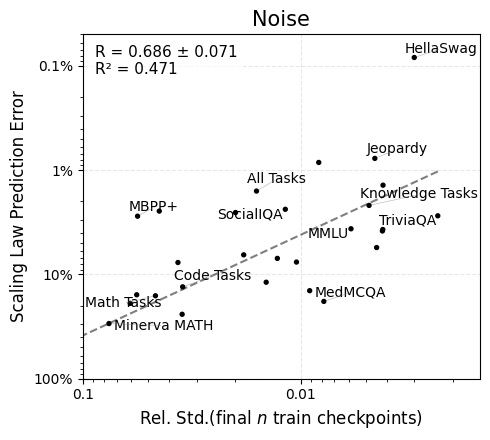

In [32]:
from plot import plot_task_scatter, CATEGORY_COLORS_SMALL

fig, axs = plt.subplots(1, 1, figsize=(5, 4.5))

plot_task_scatter(
    axs, df_results,
    y_col='rel_error:stacked:13B:bpb_to_primary', 
    ylabel='Scaling Law Prediction Error',
    # ydesc='Easier task to predict', xdesc='Lower noise around\nprediction target',

    title='Noise',

    x_col='step_rel_std:last30:primary_score:13B',
    # x_col='scaling_std_dev:stacked:13B:bpb_to_primary',
    # xlabel=r'Scaling Law $\pm 1$ Standard Deviation',
    xlabel=r'Rel. Std.(final $n$ train checkpoints)',

    labeled_tasks=['mmlu', 'socialiqa', 'triviaqa', 'hellaswag', 'mbppplus', 'multitask_math', 'multitask_code', 'multitask_knowledge', 'multitask_all', 'jeopardy', 'minerva', 'medmcqa'],
    
    percentage=False,
    invert_x=True, invert_y=True,
    log_x=True, log_y=True,
    draw_frontier=False,
    ylim={'bottom': 1, 'top': 0.0005},
    xlim={'right': 0.0015, 'left': 0.1},

    compute_fit=True,

    color='k'
)
axs.title.set_size(15)
axs.xaxis.label.set_size(12)
axs.yaxis.label.set_size(12)

axs.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0}'.format(x) if x >= 0.01 else '{:.1}'.format(x) if x >= 0.001 else '{:.2}'.format(x)))
axs.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x) if x >= 0.01 else '{:.1%}'.format(x) if x >= 0.001 else '{:.3%}'.format(x)))

axs.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/scaling_error.pdf', bbox_inches='tight', dpi=300)
plt.show()

n=36, s_err=0.5645646843192729, x_mean=-1.770423894026705, x_log spread=1.8477695253913713
olmes_core9
minerva
olmes_gen
mmlu
mmlu_pro
agi_eval
bbh
arc_challenge
arc_easy
boolq
csqa
hellaswag
openbookqa
piqa
socialiqa
winogrande
drop
gsm8k
jeopardy
squad
triviaqa
mbpp
mbppplus
codex_humaneval
codex_humanevalplus
autobencher
gsm_plus
medmcqa
multitask_all
multitask_math
multitask_code
multitask_knowledge


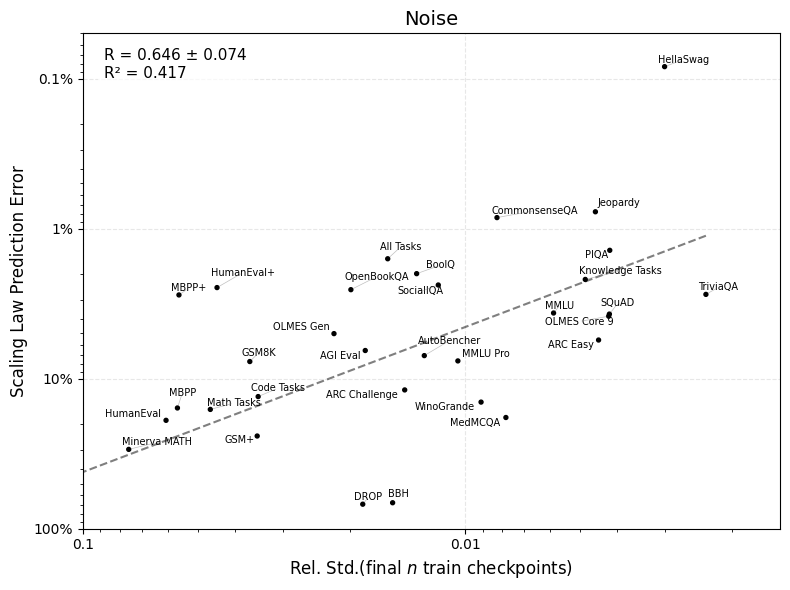

In [19]:
from plot import plot_task_scatter, CATEGORY_COLORS_SMALL

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

plot_task_scatter(
    axs, df_results,
    y_col='rel_error:stacked:13B:bpb_to_primary', 
    ylabel='Scaling Law Prediction Error',
    title='Noise',
    x_col='step_rel_std:last30:primary_score:13B',
    xlabel=r'Rel. Std.(final $n$ train checkpoints)',
    
    percentage=False,
    invert_x=True, invert_y=True,
    log_x=True, log_y=True,
    draw_frontier=False,
    ylim={'bottom': 1, 'top': 0.0005},
    xlim={'right': 0.0015, 'left': 0.1},

    compute_fit=True,

    color='k'
)
axs.title.set_size(14)
axs.xaxis.label.set_size(12)
axs.yaxis.label.set_size(12)

axs.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0}'.format(x) if x >= 0.01 else '{:.1}'.format(x) if x >= 0.001 else '{:.2}'.format(x)))
axs.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x) if x >= 0.01 else '{:.1%}'.format(x) if x >= 0.001 else '{:.3%}'.format(x)))

axs.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/scaling_error_large.pdf', bbox_inches='tight', dpi=300)
plt.show()